# Window-Based Detection using SIFT Descriptor Featuring Matching

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV
import pickle as pkl

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from dataset import *
from descriptor import *
from SlidingWindow import *
from BagOfWords import *

In [3]:
# Global Variables
run_sliding_window = False

curr_wd = os.getcwd()
example_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '004.jpg')
example_full_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '000.jpg')

## Sliding Window

In order to perform window based detection on an image, we need to construct a sliding window subroutine in order to iterate over windows in an image. In the following demonstration, a multiscale sliding window routine using image pyramids is displayed

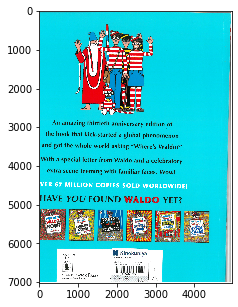

In [4]:
# Load example image 
example_image = plt.imread(example_path)
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(example_image)

In [5]:
# Sliding window routine
window_size = (100, 100)
if run_sliding_window: # Toggle demo using this variable
    for sub_image in image_pyramid(example_image, scale=1.5):
        for coordinates, window in sliding_window(sub_image, step_size=100, window_size=window_size):
            # NOTE: Can apply sub routine to process each image here

            # Extract coordinates of current bounding box
            y, x, y_end, x_end = coordinates

            sub_image_copy = sub_image.copy() 
            cv2.rectangle(sub_image_copy, (x, y), (x_end, y_end), (0, 255, 0), 2)
            cv2.imshow("Example", sub_image_copy)
            cv2.waitKey(1)
            time.sleep(0.025)

# NOTE: Running this cell block may crash the kernel. Only do so to visualise the results of sliding window

### Prepare Dataset

In [6]:
# prepare annotations:
extract_provided_annots()
extract_extra_annots()

In [7]:
# prepare list of images to use
img_lst = []
img_lst_pth = os.path.join(curr_wd, 'datasets', 'ImageSets', 'images.txt')
with open(img_lst_pth, 'r') as fp:
    contents = fp.readlines()
    for l in contents:
        file_name = l.strip()
        if file_name and file_name != '000': # exclude the example image
            img_lst.append(file_name)

In [8]:
# generate the dataset
prepare_classification_dataset(img_lst, clean=True)

### Train Classifier

After extracting the Bag Of Words from the training patches, we then train our classifer on the histogram vector features from training data patches, and test it on our validation patches

In [9]:
# load the data
from classification import *
cls_types = ['waldo_face_front']

In [11]:
sift_classifier = Classifier('sift', pos_classes=cls_types, neg_ratio=0.7)
sift_classifier.train()

---num of training instances: 1632
---num of validation instances: 408
--- fetching the vocbulary for sift
--- extracting features from the training set
--- extracting features from the positive validation set
--- predicting the validation set labels
--- precision: 0.952, recall: 0.845, f1-score: 0.896


In [12]:
# surf_classifier = Classifier('surf', pos_classes=cls_types, neg_ratio=0.7)
# surf_classifier.train()

In [13]:
# akaze_classifier = Classifier('akaze', pos_classes=cls_types, neg_ratio=0.7)
# akaze_classifier.train()

### Sliding Window Scoring

We now use our trained classifer to score each window, and threshold windows that have scores beyond a certain benchmark

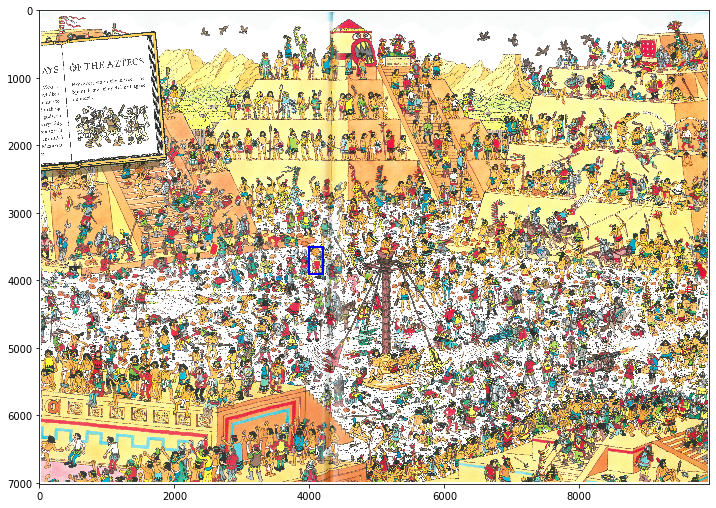

In [14]:
# Visualise window on training image
plt.rcParams['figure.figsize'] = (12.0, 12.0)
fig, ax = plt.subplots(1)

window_size = (200, 400)
step_size = 500

example_full = plt.imread(example_full_path)
ax.imshow(example_full)

rect = patches.Rectangle((4000, 3500), window_size[0], window_size[1], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

plt.show()

In [15]:
# Perform detection
from BagOfWords import *
detections = detect_with_clf(example_full, sift_classifier)
print('Number of Bounding Boxes Without Thresholding: ', len(detections))

Number of Bounding Boxes Without Thresholding:  96


In [16]:
thresholded_detection = non_max_suppression(detections, threshold=0.3, score_threshold=0.7)
len(thresholded_detection)

31

In [21]:
provided_annot_path = os.path.join(curr_wd, 'cache_anno/', 'classification', 'provided_annots.pkl')
with open(provided_annot_path, 'rb') as f:
    provided_annots = pickle.load(f)
    
grounf_truth = [0] * 4
for box in provided_annots['000.jpg']:
    coord, label = box
    if label[0] == 'waldo':
        ground_truth = coord

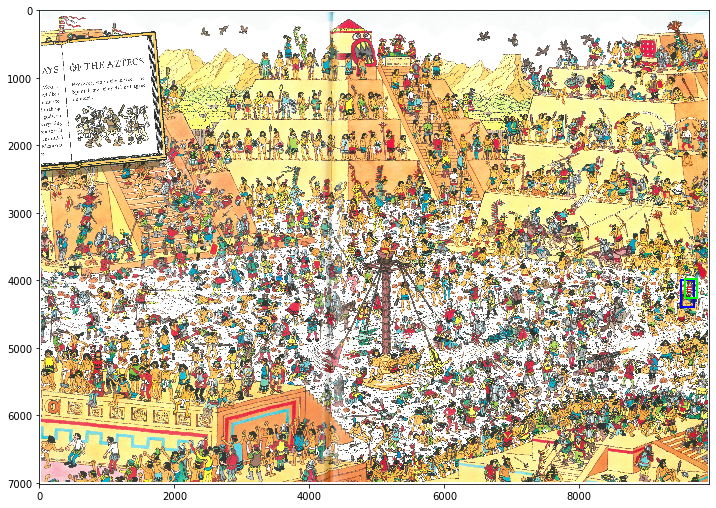

In [22]:
# Visualise detections
clone = example_full.copy()
for (x1, y1, x2, y2, score) in thresholded_detection[:1]:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)